# Image Segmentation using K-Means

## K-means based Unsupservised Segmentation

### Importing the libraries and papreprocessing the data

(330, 500, 3)


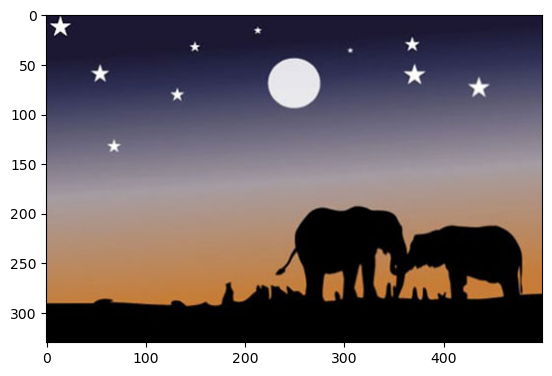

(165000, 3)


In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import random
import math
import collections
from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50
from torchvision.models.segmentation import FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image


im =  cv2.imread('./elephant.jpg') # Reads an image into BGR Format

im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
original_shape = im.shape

print(im.shape)
plt.imshow(im) # as RGB Format
plt.show()

# Flatten Each channel of the Image
all_pixels = im.reshape((-1,3))
print(all_pixels.shape)

In [2]:
def k_means_algorithm(n_clusters: int, all_pixels: np.ndarray):
    """
    Applies K-Means clustering on the provided pixel data to segment an image based on color attributes.

    Parameters:
    - n_clusters (int): The number of clusters or segments desired in the output.
    - all_pixels (np.ndarray): A 2D numpy array of shape (h x w, 3). Each row represents a pixel with its RGB values.

    Returns:
    - n_clusters: A numpy array of shape (n_clusters, 3) representing the cluster centroids in RGB format.
    - labels: A numpy array of shape (h x w) where each value is an integer label from 0 to (n_clusters-1), indicating the cluster to which each pixel belongs.
    """
    centroids = all_pixels[np.random.choice(all_pixels.shape[0], n_clusters, replace=False)]

    # Initialize variables
    labels = np.zeros(all_pixels.shape[0], dtype=int)
    dist = np.zeros((all_pixels.shape[0], n_clusters))
    totalChange = np.inf
    
    # euclidean distance 
    def euclid(coor1, coor2):
        return np.sqrt(np.sum((coor1 - coor2) ** 2))
    
    while totalChange > 1e-3:
        # Calculate distances from all pixels to each centroid
#         for i in range(all_pixels.shape[0]):
#             for j in range(n_clusters):               
#                 dist[i, j] = euclid(all_pixels[i], centroids[j])

        # optimized version of above
        for i in range(n_clusters): 
            dist[:, i] = np.linalg.norm(all_pixels - centroids[i], axis=1)

        
        # if no change, end
        if np.array_equal(labels, np.argmin(dist, axis=1)):
            break
        
        labels = np.argmin(dist, axis=1) # updates labels to contain the nearest centroid
        
        temp = np.zeros((n_clusters, all_pixels.shape[1]))
        
        # Calculate the new centroids and the total change
        for i in range(n_clusters):
            cluster = all_pixels[labels == i]
            
            if cluster.size > 0:
                temp[i] = cluster.mean(axis=0)
            else:
                temp[i] = all_pixels[np.random.choice(all_pixels.shape[0], 1)]

    
        totalChange = euclid(temp, centroids)
        
#         print(totalChange) # for visualization
        centroids = temp
    
    n_clusters = centroids
    return n_clusters, labels

dominant_colors = 4
centers, labels = k_means_algorithm(dominant_colors, all_pixels)

# Convert to Integer format
centers = np.array(centers, dtype='uint8')

### What kind of color are cluster centers presented?

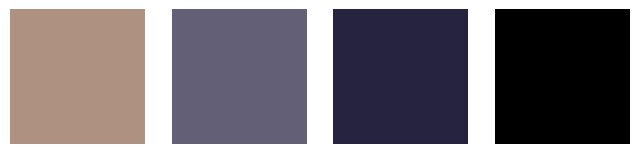

In [3]:
def analysis_colors_and_plot(centers: np.ndarray):
    """
    Analyzes the RGB values of the cluster centers and provides a description of the colors.
    Additionally, it plots the colors for a visual representation.

    Parameters:
    - centers (np.ndarray): A 2D numpy array of shape (n_clusters, 3) representing the cluster centroids in RGB format.

    Returns:
    - colors: A list of color(maybe int tuple) where each is a description of the color represented by the corresponding cluster center.
    """
    colors = []
    plt.figure(0,figsize=(8,2))

    # Storing info in color array
    colors = []
    i = 1

    for each_col in centers:
        plt.subplot(1,centers.shape[0],i)
        plt.axis("off")
        i+=1
        
        colors.append(each_col)
        
        # Color Swatch
        a = np.zeros((100,100,3),dtype='uint8')
        a[:,:,:] = each_col
        plt.imshow(a)
        
    plt.show()
    return colors

colors = analysis_colors_and_plot(centers)

### Show the segmented images

(165000, 3)


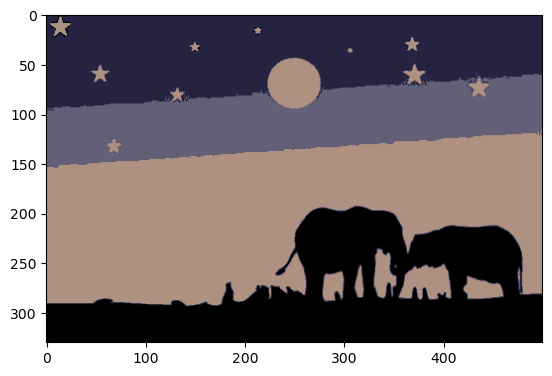

In [4]:
# Iterate over the image
def match_color_to_all_pixels(colors: list, labels: np.ndarray, new_img: np.ndarray, original_shape: tuple) -> np.ndarray:
    """
    Maps the cluster centroids (colors) to the original image pixels based on the labels.

    Parameters:
    - colors (list): A 2D numpy array of shape (n_clusters, 3) representing the cluster centroids in RGB format.
    - labels (np.ndarray): A 1D numpy array of shape (h x w) where each value is an integer label from 0 to (n_clusters-1), indicating the cluster to which each pixel belongs.
    - new_img (np.ndarray): A numpy array to store the resultant segmented image. It should have the same shape as the original image.
    - original_shape (tuple): A tuple representing the original shape of the image, i.e., (h, w, 3).

    Returns:
    - np.ndarray: The resultant segmented image.
    """
    
    for ix in range(new_img.shape[0]):
        new_img[ix] = colors[labels[ix]]
        
    new_img = new_img.reshape((original_shape))
      
    return new_img

width, height, chanles = im.shape
new_img = np.zeros((width*height,chanles),dtype='uint8')
print(new_img.shape)

new_img = match_color_to_all_pixels(colors, labels, new_img, original_shape)

plt.imshow(new_img)
plt.show()



### Segmented images for different values of K = 2, 4, 6, 8, 10, draw in one line

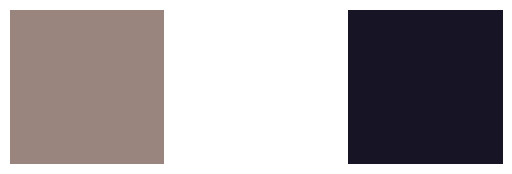

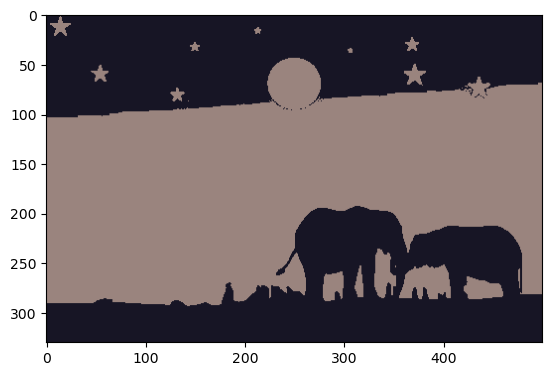

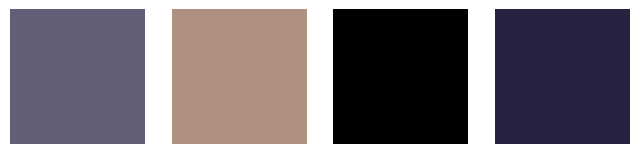

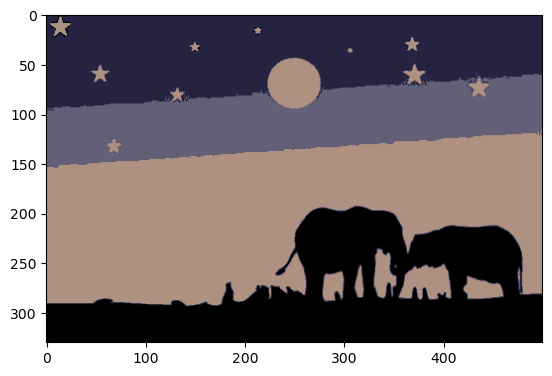

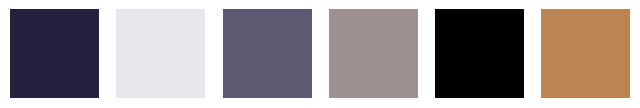

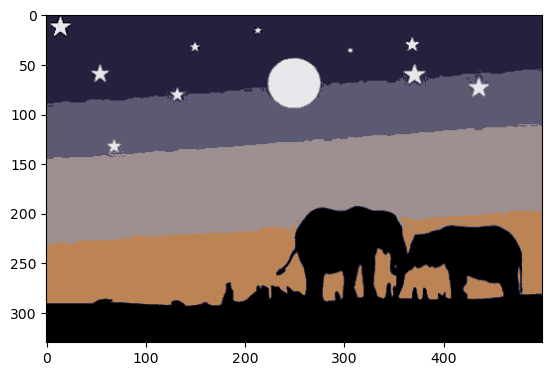

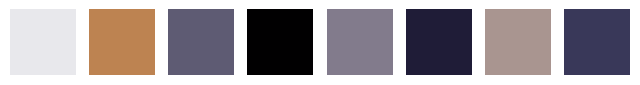

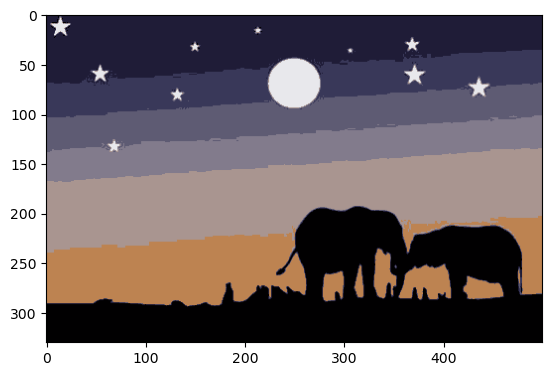

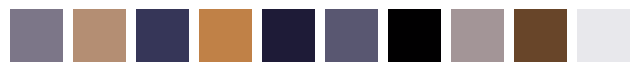

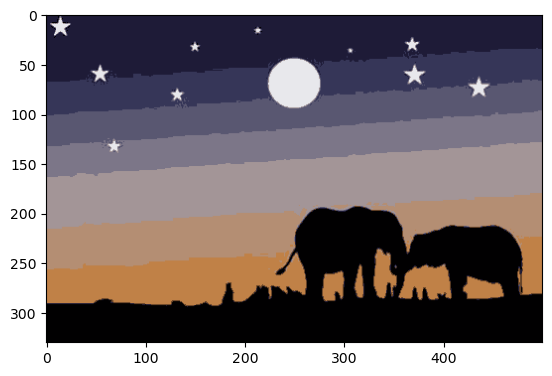

In [5]:
for val in [2, 4, 6, 8, 10]:
    centers, labels = k_means_algorithm(val, all_pixels)
    centers = np.array(centers, dtype='uint8')
    
    colors = analysis_colors_and_plot(centers)
    
    width, height, chanles = im.shape
    new_img = np.zeros((width*height,chanles),dtype='uint8')
    new_img = match_color_to_all_pixels(colors, labels, new_img, original_shape)

    plt.imshow(new_img)
    plt.show()

### Example for features and segmentation via FCN

/Users/oscarh/anaconda3/envs/assignment2/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


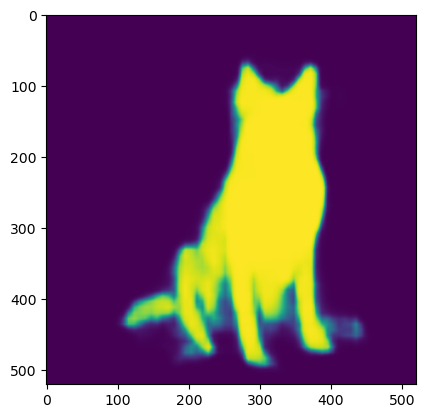

In [6]:
from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

img = read_image("./dog.jpg")

# Step 1: Initialize model with the best available weights
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and visualize the prediction
prediction = model(batch)["out"]

normalized_masks = prediction.softmax(dim=1)
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
mask = normalized_masks[0, class_to_idx["dog"]]
mask_img = to_pil_image(mask)

plt.imshow(mask_img)

### Segment image via features from FCN and K-means, set K = 2, 4, 6, 8

In [8]:
from torch.nn import functional as F
import numpy as np

orginal_features = model.backbone(batch)["out"]
features = F.interpolate(orginal_features, size=img.shape[-2:], mode="bilinear", align_corners=False)
features = (features.squeeze(0).reshape((2048, -1))).permute(1, 0).detach().numpy() # Now, features is of shape (H*W, C), where C is learned features instead of colors

labels = []

for k in [2, 4, 6, 8]:
    center, temp = k_means_algorithm(k, features)
    labels.append(temp)

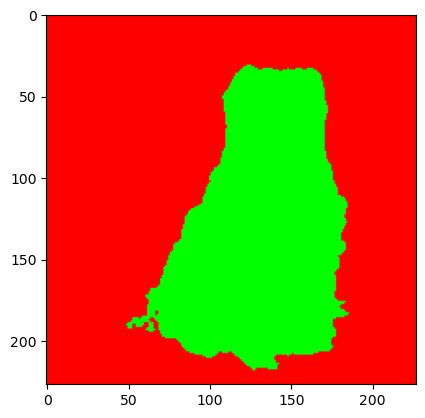

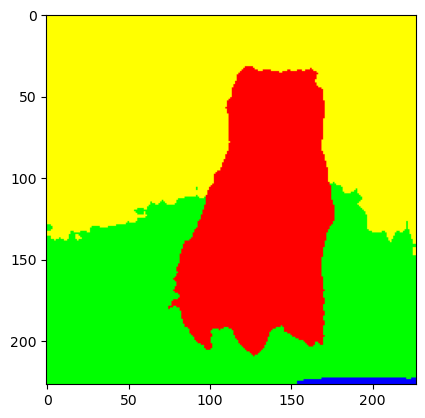

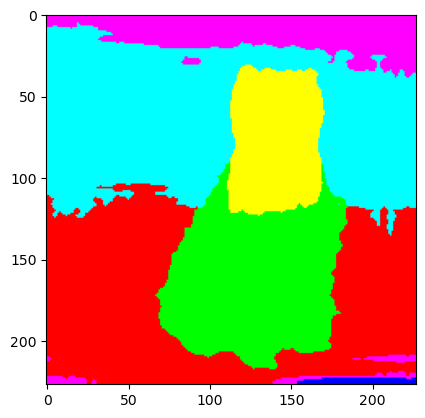

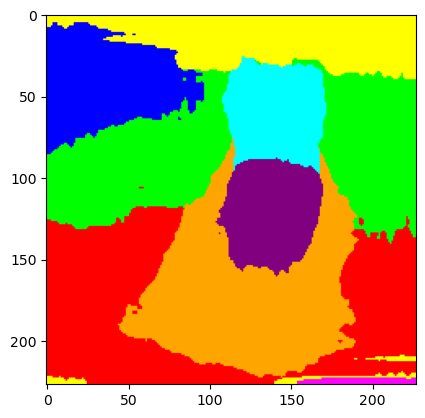

In [9]:
for k in range(4):
    chanles, height, width  = img.shape
    original_shape = (height, width, chanles)

    colors = [(255, 0, 0),    
              (0, 255, 0),   
              (0, 0, 255),   
              (255, 255, 0),  
              (255, 0, 255),  
              (0, 255, 255),  
              (128, 0, 128), 
              (255, 165, 0)] 
    
    new_img = np.zeros((width*height,chanles), dtype='uint8')
    new_img = match_color_to_all_pixels(colors, labels[k], new_img, original_shape)
    new_img = new_img.reshape((height, width, chanles))

    plt.imshow(new_img)
    plt.show()